In [0]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from time import time

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def all_same(items):
  return len(set(items)) == 1

# Load training data from csv file
try:
    data = pd.read_csv("https://github.com/briceicle/capstone/raw/master/data/train.csv")
    test = pd.read_csv("https://github.com/briceicle/capstone/raw/master/data/test.csv")
    print("Digits dataset has {} samples with {} features each.".format(*data.shape))
except Exception as e:
    print("Dataset could not be loaded. Is the dataset missing?")
    print(e)

Digits dataset has 42000 samples with 785 features each.


In [0]:
# Extract feature columns
feature_cols = list(data.columns[1:])

# Extract target column 'label'
target_col = data.columns[0]

# Separate the data into feature data and target data (X and y, respectively)
X = data[feature_cols]
y = data[target_col]

Total number of samples: 42000
Number of features: 784


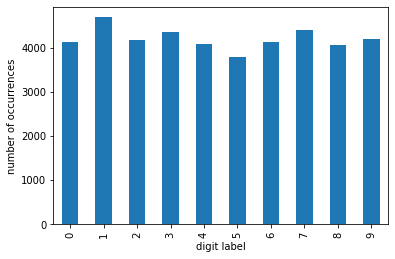

In [0]:
# Calculate number of samples
n_images = data.shape[0]

# Calculate number of features
n_features = data.shape[1] - 1

# Plot number of occurrences of each label
plot = data.label.groupby(data.label).count().plot(kind="bar")
plot.set_xlabel("digit label")
plot.set_ylabel("number of occurrences")

# Print the results
print("Total number of samples: {}".format(n_images))
print("Number of features: {}".format(n_features))

In [0]:
images = test.iloc[:,:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(28000,784)


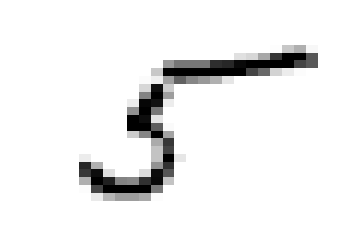

In [0]:
# display image
def display2(img):
    # (784) => (28,28)
    one_image = img.reshape(28, 28)
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(one_image, **dict(aspect='auto', cmap='binary', interpolation='nearest'))

# output image
display2(images[23])

count    42000.000000
mean        33.408911
std         11.083130
min          6.487245
25%         25.393814
50%         32.610969
75%         40.363839
max        101.381378
dtype: float64


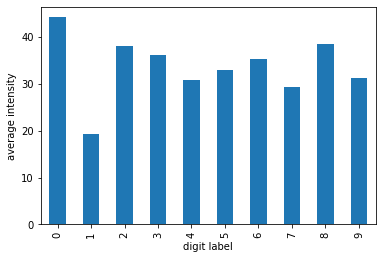

In [0]:
# compute the average intensity (the average value of a pixel in an image)
data_intensity = X.mean(axis=1)

# Plot average intensity of each label
plot = data_intensity.groupby(data.label).mean().plot(kind="bar")
plot.set_xlabel("digit label")
plot.set_ylabel("average intensity")

print(data_intensity.describe())

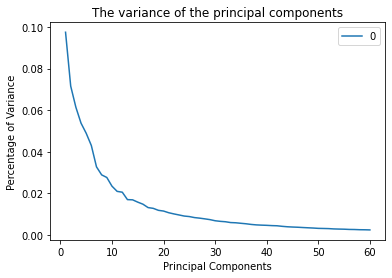

In [0]:
# Apply PCA by fitting the data with only 60 dimensions
pca = PCA(n_components=60).fit(X)
# Transform the data using the PCA fit above
X = pca.transform(X)
y = y.values

plot = pd.DataFrame(pca.explained_variance_ratio_, index=np.arange(1, pca.n_components_ + 1)).plot()
plot.set_title('The variance of the principal components')
plot.set_xlabel("Principal Components")
plot.set_ylabel("Percentage of Variance");

In [0]:
# Shuffle and split the dataset into the number of training and testing points above
sss = model_selection.StratifiedShuffleSplit(3, test_size=0.4, random_state=42)
for train_index, test_index in sss.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [0]:
# Fit a KNN classifier on the training set
knn_clf = KNeighborsClassifier(n_neighbors=300, p=2)
knn_clf.fit(X_train, y_train);

In [0]:
# Initialize the array of predicted labels
y_pred = np.empty(len(y_test), dtype=np.int)

start = time()

# Find the nearest neighbors indices for each sample in the test set
kneighbors = knn_clf.kneighbors(X_test, return_distance=False)

# For each set of neighbors indices
for idx, indices in enumerate(kneighbors):
  # Find the actual training samples & their labels
  neighbors = [X_train[i] for i in indices]
  neighbors_labels = [y_train[i] for i in indices]
  
  # if all labels are the same, use it as the prediction
  if all_same(neighbors_labels):
    y_pred[idx] = neighbors_labels[0]
  else:
    # else fit a SVM classifier using the neighbors, and label the test samples
    svm_clf = svm.SVC(C=8, kernel='rbf', decision_function_shape='ovo', random_state=42)
    # svm_clf = SVC(C=1.0, kernel='rbf', degree=3, gamma=1/(n_features * np.var(neighbors)), coef0=0.0, 
    #            shrinking=True, probability=False, tol=0.001, cache_size=200, 
    #            class_weight=None, verbose=False, max_iter=-1, 
    #            decision_function_shape='ovr', random_state=None)
    svm_clf.fit(neighbors, neighbors_labels)
    label = svm_clf.predict(X_test[idx].reshape(1, -1))

    y_pred[idx] = label
end = time()

print(accuracy_score(y_test, y_pred))
print("Made predictions in {:.4f} seconds.".format(end - start))

0.9827380952380952
Made predictions in 153.0029 seconds.


In [27]:
start = time()
test_X = test[feature_cols]
pca_test = PCA(n_components=60).fit(test_X)
test_X = pca_test.transform(test_X)
y_pred_test = np.empty(len(test_X), dtype=np.int)
kneighbors = knn_clf.kneighbors(test_X, return_distance=False)
for idx, indices in enumerate(kneighbors):
  neighbors = [X_train[i] for i in indices]
  neighbors_labels = [y_train[i] for i in indices]
  if all_same(neighbors_labels):
    y_pred_test[idx] = neighbors_labels[0]
  else:
    svm_clf = svm.SVC(C=8, kernel='rbf', decision_function_shape='ovo', random_state=42)
    svm_clf.fit(neighbors, neighbors_labels)
    y_pred_test[idx] = svm_clf.predict(test_X[idx].reshape(1, -1))
# save to csv in order to uploadd it to kaggle
pd.DataFrame(list(zip(np.arange(1, y_pred_test.shape[0] + 1),y_pred_test)), 
             columns=['ImageId', 'Label']).to_csv('predictions.csv', index=False)
end = time()
print("Made submission predictions in {:.4f} seconds.".format(end - start))

AttributeError: ignored